from: http://mc-stan.org/users/documentation/case-studies/qr_regression.html

In [1]:
% matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
np.random.seed(123)

import theano.tensor as tt
import pymc3 as pm
import patsy
import pandas as pd

In [41]:
N = 5000
x = np.random.normal(10, 1, size=N)
x2 = np.power(x, 2)

X = np.stack((np.ones_like(x), x, x2), axis=1)


beta_true = np.atleast_2d(np.array([-0.275, 2.5, -1.0])).T

sd_true = 0.8
mu_true = np.dot(X, beta_true)
y = np.random.normal(mu_true, sd_true)

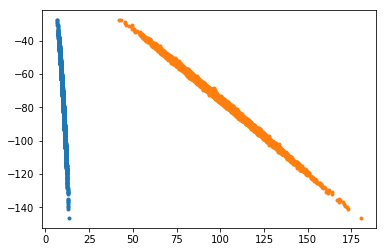

In [47]:
plt.plot(x, y, '.'), plt.plot(x2, y, '.');

In [48]:
X[:5, :]

array([[  1.        ,  10.11744371, 102.36266717],
       [  1.        ,   8.91124825,  79.41034541],
       [  1.        ,   8.70271756,  75.73729297],
       [  1.        ,   9.82560411,  96.54249614],
       [  1.        ,  10.06606322, 101.32562879]])

In [49]:
with pm.Model() as model:
    
    beta = pm.Normal('beta', mu=0, sd=10, shape=X.shape[1])
    mu = tt.dot(X, beta)
    
    sd = pm.HalfNormal('sd', sd=10)
    
    likelihood = pm.Normal('likelihood', mu=mu, sd=sd, observed=y.flatten())
    trace = pm.sample(draws=1000, tune=1000, chains=2, cores=1, random_seed=123, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, beta]
100%|███████████████████████████████████████| 2000/2000 [02:44<00:00, 12.15it/s]
The number of effective samples is smaller than 25% for some parameters.


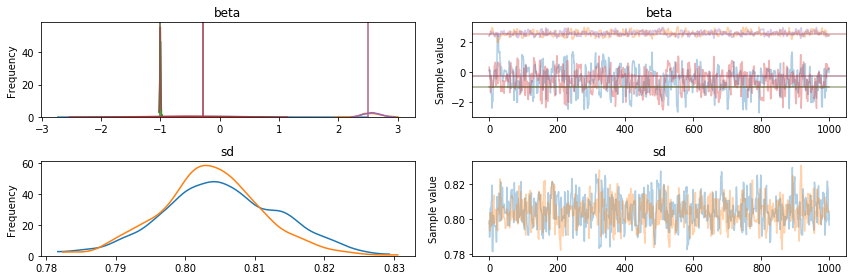

In [50]:
pm.traceplot(trace, lines={'beta':beta_true});

In [52]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta__0,-0.561816,0.759550,0.035068,-2.195405,0.769376,394.930098,1.000820
beta__1,2.560834,0.152772,0.007035,2.300161,2.896910,394.288971,1.000832
beta__2,-1.003350,0.007652,0.000350,-1.019252,-0.989512,397.023665,1.000812
sd,0.804318,0.007918,0.000311,0.788788,0.820150,645.639705,1.008646


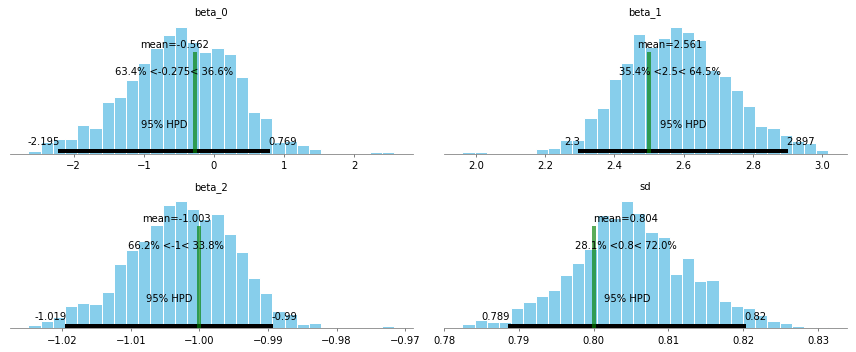

In [70]:
pm.plot_posterior(trace, ref_val=np.append(beta_true.flatten(), sd_true));

## QR decomposition

In [71]:
Q, R = np.linalg.qr(X)
Q = Q * N
R = R / N
R_inv = np.linalg.inv(R)

Q.shape, R.shape

((5000, 3), (3, 3))

In [77]:
Q

array([[-70.71067812,   9.05914789,  49.89824134],
       [-70.71067812, -76.01803376,  -6.00749262],
       [-70.71067812, -90.72643222, -30.63270341],
       ...,
       [-70.71067812,  86.48634627, -27.47337784],
       [-70.71067812,  65.04452354,   6.18896844],
       [-70.71067812,  -2.61965338,  50.96134662]])

In [79]:
with pm.Model() as model:
    
    beta_tilde = pm.Normal('beta_tilde', mu=0, sd=1, shape=X.shape[1])
    beta = pm.Deterministic('beta', tt.dot(R_inv, beta_tilde))
    
    mu = tt.dot(Q, beta_tilde)
    sd = pm.HalfNormal('sd', sd=10)
    
    likelihood = pm.Normal('likelihood', mu=mu, sd=sd, observed=y.flatten())
    trace = pm.sample(draws=1000, tune=1000, chains=2, cores=1, random_seed=123, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, beta_tilde]
100%|██████████████████████████████████████| 2000/2000 [00:18<00:00, 110.79it/s]


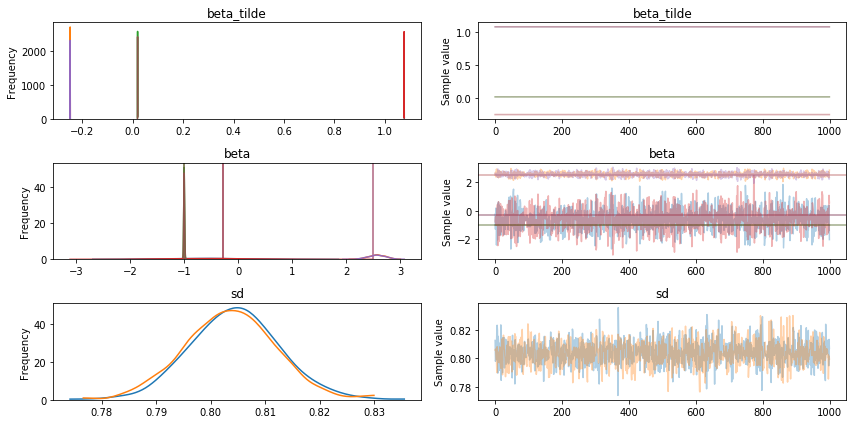

In [80]:
pm.traceplot(trace, lines={'beta':beta_true});

In [81]:
pm.summary(trace, varnames=['beta', 'sd'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta__0,-0.593975,0.804984,0.015616,-2.041567,1.063780,2991.466750,0.999515
beta__1,2.567464,0.162483,0.003130,2.233051,2.858312,2992.205963,0.999521
beta__2,-1.003690,0.008155,0.000156,-1.019012,-0.987603,2988.692819,0.999524
sd,0.803901,0.008263,0.000175,0.788361,0.820465,1879.611670,1.002464


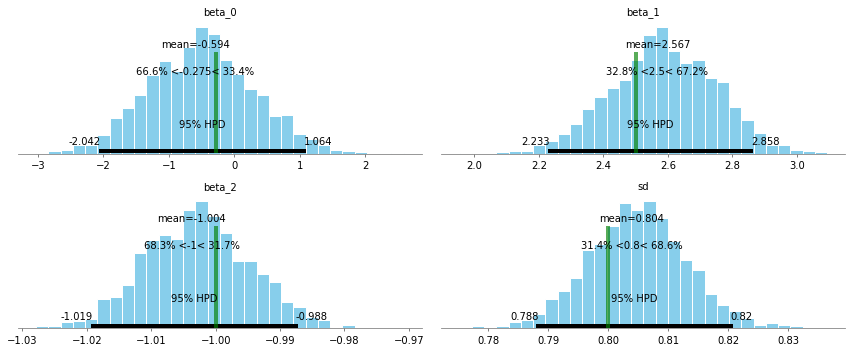

In [82]:
pm.plot_posterior(trace, varnames=['beta', 'sd'], ref_val=np.append(beta_true.flatten(), sd_true));